In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load and preprocess the data
excel_data = pd.ExcelFile('./DAS-Saguling.xlsx')
data = excel_data.parse('Sheet1')
data.head()


,TAHUN,Jan,Peb,Mar,Apr,Mei,Jun,Jul,Agt,Sep,Okt,Nop,Des
0,1986,136.0,110.00,239.52,175.00,88.42,90.60,80.78,60.40,78.51,84.89,165.00,109.00
1,1987,114.0,102.31,165.00,138.00,78.22,58.30,24.70,12.30,12.40,29.20,56.40,145.00
2,1988,197.0,123.00,163.00,79.16,140.00,65.70,20.00,19.40,12.95,83.20,116.00,53.00
3,1989,183.0,142.00,115.00,149.00,155.00,107.00,70.90,40.12,20.60,19.60,77.70,128.00
4,1990,101.0,223.00,116.00,174.00,92.70,71.77,35.10,59.38,27.49,19.90,32.43,146.23


In [76]:
# Melt the DataFrame to have 'Date' and 'Inflow' columns
data_melted = data.melt(id_vars=['TAHUN'], var_name='Month', value_name='Inflow')

# Convert months to numeric using map
month_mapping = {
    'Jan': 1, 'Peb': 2, 'Mar': 3, 'Apr': 4, 'Mei': 5, 'Jun': 6,
    'Jul': 7, 'Agt': 8, 'Sep': 9, 'Okt': 10, 'Nop': 11, 'Des': 12
}
data_melted['Month'] = data_melted['Month'].map(month_mapping).astype(int)

# Convert 'TAHUN' to integers
data_melted['TAHUN'] = data_melted['TAHUN'].astype(int)

# Create the 'Date' column using TAHUN and Month
data_melted['Date'] = pd.to_datetime(data_melted['TAHUN'].astype(str) + '-' + data_melted['Month'].astype(str) + '-01', format='%Y-%m-%d')

# Sort by date and set as index
data_melted = data_melted.sort_values(by='Date').set_index('Date')
data_melted = data_melted[['Inflow']]

In [77]:

data_melted = data_melted.dropna()

# Normalize the inflow data
scaler = MinMaxScaler(feature_range=(0, 1))
data_melted['Inflow'] = scaler.fit_transform(data_melted[['Inflow']])


In [78]:
# Prepare data for LSTM with 6-month prediction
def create_dataset(data, time_step=1, predict_step=6):
    X, y = [], []
    for i in range(len(data) - time_step - predict_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step:i + time_step + predict_step, 0])
    return np.array(X), np.array(y)

# Convert DataFrame to numpy array
data_array = data_melted.values
time_step = 12  # Using the past 12 months to predict the next 6 months

X, y = create_dataset(data_array, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Check shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (435, 12, 1), y shape: (435, 6)


In [79]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(6))  # Output for next 6 months

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

In [80]:
# Train the model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1069
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0498
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0450
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0470
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0424
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0419
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0409
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0375
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0373
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0352
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0342
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0330
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0297
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296
Epoch 16/50
14/14 ━

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Length of latest_6_actual: 6
Length of latest_6_predicted: 6
Length of latest_6_dates: 6

Comparison of Actual vs Predicted Inflow (Latest 6 Months):
+----------------+--------------------+--------------------+
|     Month      |   Actual Inflow    |  Predicted Inflow  |
+----------------+--------------------+--------------------+
|   April 2023   | 92.22366666666669  | 128.89602661132812 |
|    May 2023    | 106.98161290322585 | 105.48631286621094 |
|   June 2023    | 40.41733333333333  | 80.72195434570312  |
|   July 2023    | 21.76645161290323  | 51.63243865966797  |
|  August 2023   |        9.68        | 40.17131042480469  |
| September 2023 | 7.338666666666668  | 46.24769592285156  |
+----------------+--------------------+--------------------+


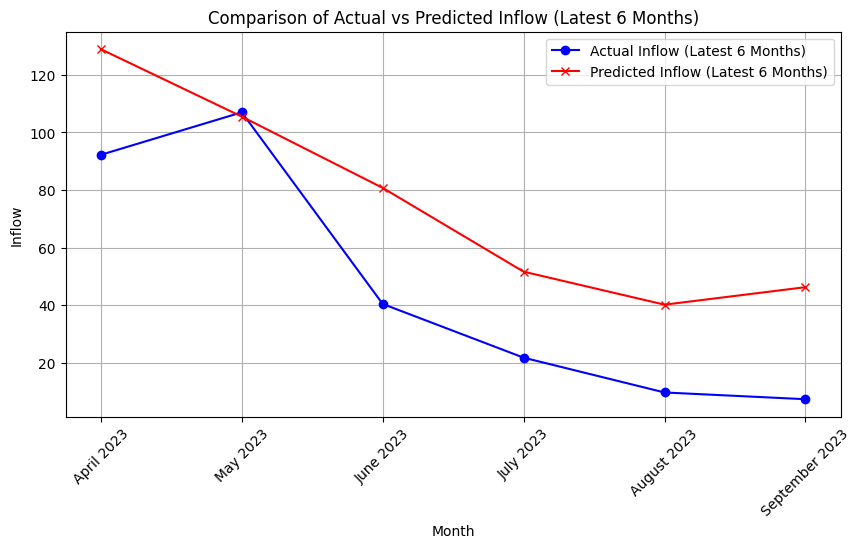


Mean Absolute Error (MAE): 29.62
Root Mean Square Error (RMSE): 32.42


In [81]:
# Make predictions on the entire training set (X) to get predicted values for every point in the training data
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)  # Inverse scale predictions

# Inverse scale the actual inflow data
actual_inflow_data = scaler.inverse_transform(data_array)

# Ensure that we're taking exactly 6 values for each
latest_6_actual = actual_inflow_data[-6:].flatten()     # Take only the last 6 values for actual inflow
latest_6_predicted = predictions[-1][-6:].flatten()     # Select only the last 6 predictions from the last prediction set
latest_6_dates = data_melted.index[-6:].strftime('%B %Y')  # Convert dates to "Month Year" format

# Print lengths for debugging
print("Length of latest_6_actual:", len(latest_6_actual))
print("Length of latest_6_predicted:", len(latest_6_predicted))
print("Length of latest_6_dates:", len(latest_6_dates))

# Create a DataFrame to display actual vs. predicted inflow for the latest 6 months
comparison_df = pd.DataFrame({
    'Month': latest_6_dates,
    'Actual Inflow': latest_6_actual,
    'Predicted Inflow': latest_6_predicted
})

# Print comparison DataFrame as a table
print("\nComparison of Actual vs Predicted Inflow (Latest 6 Months):")
print(tabulate(comparison_df, headers='keys', tablefmt='pretty', showindex=False))

# Plotting the comparison
plt.figure(figsize=(10, 5))
plt.plot(comparison_df['Month'], comparison_df['Actual Inflow'], marker='o', color='blue', label='Actual Inflow (Latest 6 Months)')
plt.plot(comparison_df['Month'], comparison_df['Predicted Inflow'], marker='x', color='red', label='Predicted Inflow (Latest 6 Months)')
plt.title('Comparison of Actual vs Predicted Inflow (Latest 6 Months)')
plt.xlabel('Month')
plt.ylabel('Inflow')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Calculate and print RMSE and MAE
mae = mean_absolute_error(latest_6_actual, latest_6_predicted)
rmse = np.sqrt(mean_squared_error(latest_6_actual, latest_6_predicted))
print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Shape of next_month_pred: (1, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Shape of next_month_pred: (1, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Shape of next_month_pred: (1, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Shape of next_month_pred: (1, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Shape of next_month_pred: (1, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Shape of next_month_pred: (1, 6)

Predicted Inflow for the Next 6 Months:
+---------------+--------------------+
|     Month     |  Predicted Inflow  |
+---------------+--------------------+
| October 2023  | 91.99842834472656  |
| November 2023 | 105.07261657714844 |
| December 2023 | 122.45941925048828 |
| January 2024  | 126.02210998535156 |
| February 2024 | 139.59092712402344 |
|  March 2024   |   145.119140625    |
+---------------+--------------------+


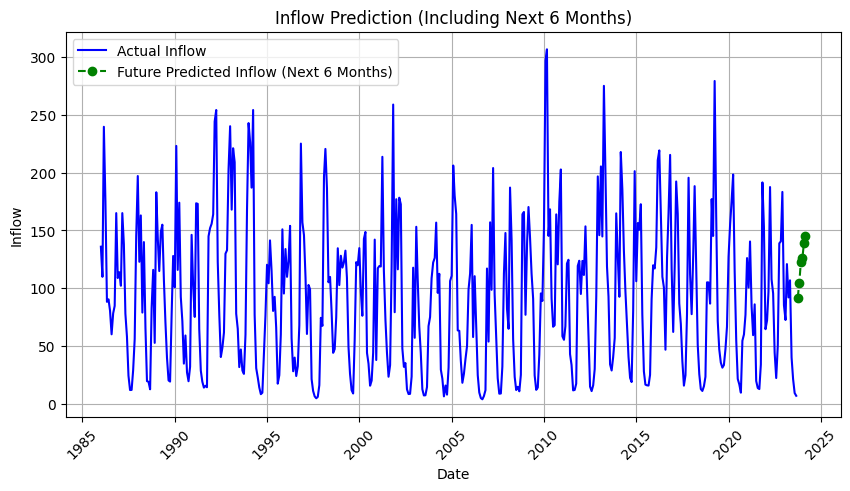

In [82]:
# Load the last sequence to use as input for predicting the next 6 months
last_sequence = data_array[-time_step:].reshape(1, time_step, 1)

# Predict inflow for each of the next 6 months
future_predictions = []
for _ in range(6):
    # Predict the next month
    next_month_pred = model.predict(last_sequence)

    # Check the shape of the prediction
    print("Shape of next_month_pred:", next_month_pred.shape)  # Debugging line
    
    # Inverse transform the prediction to get it back to the original scale
    next_month_pred_inverse = scaler.inverse_transform(next_month_pred)

    # Append the scalar value to the future predictions list
    future_predictions.append(next_month_pred_inverse[0][0])
    
    # Update the last_sequence with the predicted value
    # Reshape next_month_pred if necessary
    if next_month_pred.shape == (1, 1):  # If the prediction shape is (1, 1)
        next_month_pred_reshaped = next_month_pred.reshape(1, 1, 1)  # Shape (1, 1, 1)
    elif next_month_pred.shape == (1, 6):  # If the prediction shape is (1, 6)
        next_month_pred_reshaped = next_month_pred.reshape(1, 6, 1)  # Shape (1, 6, 1)
    else:
        # Handle other shapes if needed, possibly an error
        raise ValueError(f"Unexpected shape for next_month_pred: {next_month_pred.shape}")
    
    # Remove the first time step and add the new prediction
    last_sequence = np.append(last_sequence[:, 1:, :], next_month_pred_reshaped[:, :1, :], axis=1)

# Generate month labels for the next 6 months
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=6, freq='MS')
future_month_labels = future_dates.strftime('%B %Y')  # Format as "Month Year"

# Create a DataFrame for the 6-month future predictions
future_df = pd.DataFrame({
    'Month': future_month_labels,
    'Predicted Inflow': future_predictions
})

# Print future predictions as a table
print("\nPredicted Inflow for the Next 6 Months:")
print(tabulate(future_df, headers='keys', tablefmt='pretty', showindex=False))

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data_melted.index, scaler.inverse_transform(data_array), color='blue', label='Actual Inflow')
plt.plot(future_dates, future_predictions, marker='o', color='green', linestyle='--', label='Future Predicted Inflow (Next 6 Months)')
plt.title('Inflow Prediction (Including Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('Inflow')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()